In [1]:
'''
Evaluation the mayo results
'''

'\nEvaluation the mayo results\n'

In [16]:
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import imageio

from IPython import display

from recon_fp.sparse.locations import working_dir

import ct_projector.projector.numpy as ct_base
import ct_projector.projector.numpy.parallel as ct_proj

In [3]:
nview = 288
names = ['L291', 'L143', 'L067', 'ACR']
tag = 'l2_depth_4'
device = 3

prj_dir = os.path.join(working_dir, 'mayo/data', str(nview))
input_dir = os.path.join(working_dir, 'mayo/train', str(nview), tag, 'valid')
postir_dir = os.path.join(working_dir, 'mayo/train', str(nview), tag, 'prj_recon')

output_dir = os.path.join(working_dir, 'mayo/train', str(nview), tag, 'snapshots')
os.makedirs(output_dir, exist_ok=True)

In [4]:
def load_dataset(name, input_dir, postir_dir, prj_dir, device, nview):
    norm = 1000
    offset = -1

    ct_base.set_device(device)
    projector = ct_base.ct_projector()
    projector.from_file('./data/geometry_para.cfg')
    projector.nview = nview
    projector.dv = 1
    projector.dz = 1
    angles = projector.get_angles()

    print('Loading images...', flush=True)
    imgs = {}
    imgs['x'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(input_dir, name + '.x.nii.gz')))
    imgs['y'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(input_dir, name + '.y.nii.gz')))
    imgs['pred'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(input_dir, name + '.pred.nii.gz')))
    imgs['postir'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(postir_dir, name + '.postir.nii.gz')))
    for tag in imgs:
        imgs[tag] = (imgs[tag].astype(np.float32) / norm - offset)[np.newaxis]

    print('Loading postir...', flush=True)
    prjs = {}
    prjs['y'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(prj_dir, name + '.prj.nii.gz'))) / 0.019
    prjs['postir'] = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(postir_dir, name + '.prj_recon.nii.gz'))) / 0.019
    for tag in prjs:
        prjs[tag] = prjs[tag].astype(np.float32)[np.newaxis]
    print('Forward projection...', flush=True)
    for tag in imgs:
        if tag in prjs:
            continue
        projector.nv = imgs[tag].shape[1]
        projector.nz = imgs[tag].shape[1]
        prjs[tag] = ct_proj.distance_driven_fp(projector, imgs[tag], angles)

    return imgs, prjs

In [5]:
def load_all_data(names, input_dir, postir_dir, prj_dir, device, nview):
    imgs = {}
    prjs = {}

    for name in names:
        print('Loading', name, flush=True)
        imgs[name], prjs[name] = load_dataset(name, input_dir, postir_dir, prj_dir, device, nview)

    return imgs, prjs

In [6]:
def hann_filter(prj):
    '''
    Apply the Hann filter window on the projection
    '''
    filter_len = 2 * prj.shape[-1] - 1
    hann_freq = 0.5 + 0.5 * np.cos(2 * np.pi * np.arange(filter_len) / filter_len)

    # padding
    pad_shape = list(prj.shape)
    pad_shape[-1] = prj.shape[-1] - 1
    prj_pad = np.concatenate([prj, np.zeros(pad_shape)], -1)

    # fft domain filter
    prj_pad_freq = np.fft.fft(prj_pad, axis=-1)
    prj_pad_freq *= hann_freq
    prj_pad = np.fft.ifft(prj_pad_freq, axis=-1)
    prj_hann = prj_pad[..., :prj.shape[-1]]
    prj_hann = np.real(prj_hann).astype(np.float32)

    return prj_hann

In [38]:
def crop_window(img, vmin=None, vmax=None):
    img = img.copy()

    if vmin is not None:
        img[img < vmin] = vmin
    if vmax is not None:
        img[img > vmax] = vmax

    return img


In [7]:
imgs, prjs = load_all_data(names, input_dir, postir_dir, prj_dir, device, nview)

print('Filter original projections...', flush=True)
for name in prjs:
    prjs[name]['y'] = hann_filter(prjs[name]['y'])

Loading L291
Loading images...
Loading postir...
Forward projection...
Loading L143
Loading images...
Loading postir...
Forward projection...
Loading L067
Loading images...
Loading postir...
Forward projection...
Loading ACR
Loading images...
Loading postir...
Forward projection...
Filter original projections...


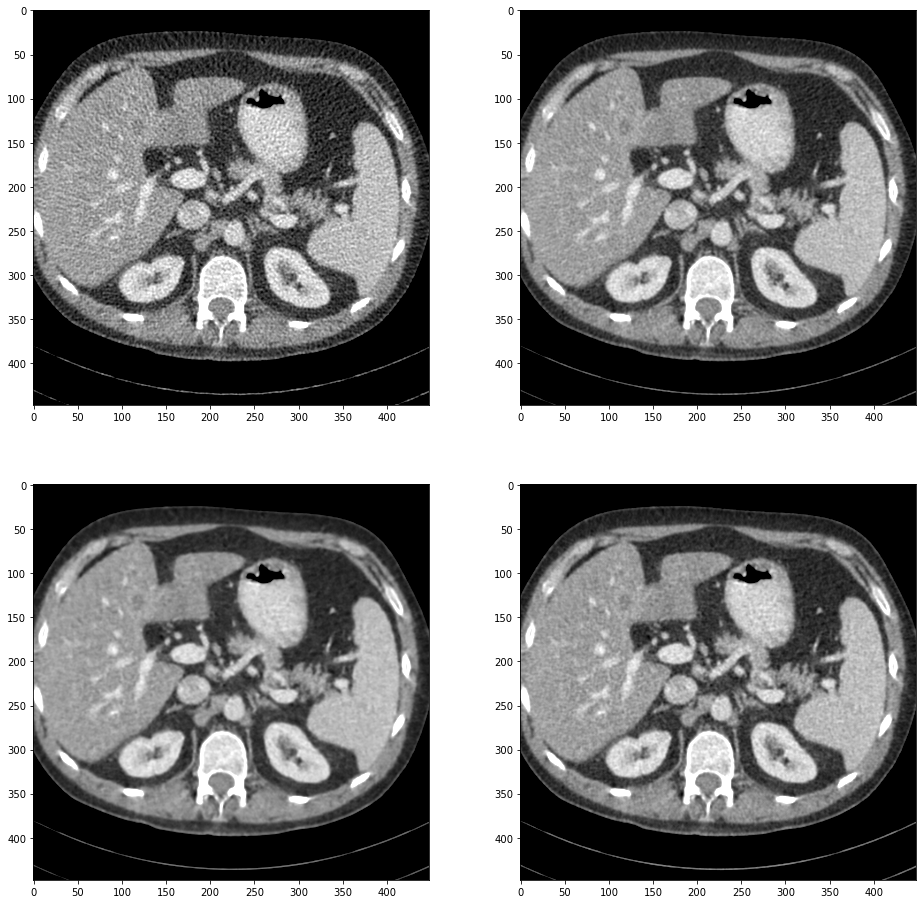

In [40]:
# show plot
show_name = 'L291'
show_tag = ['x', 'y', 'pred', 'postir']
margin = 96
show_slice = 78

plt.figure(figsize=[16, 16])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(imgs[show_name][show_tag[i]][0, show_slice, margin:-margin, margin:-margin], 'gray', vmin=0.84, vmax=1.24)

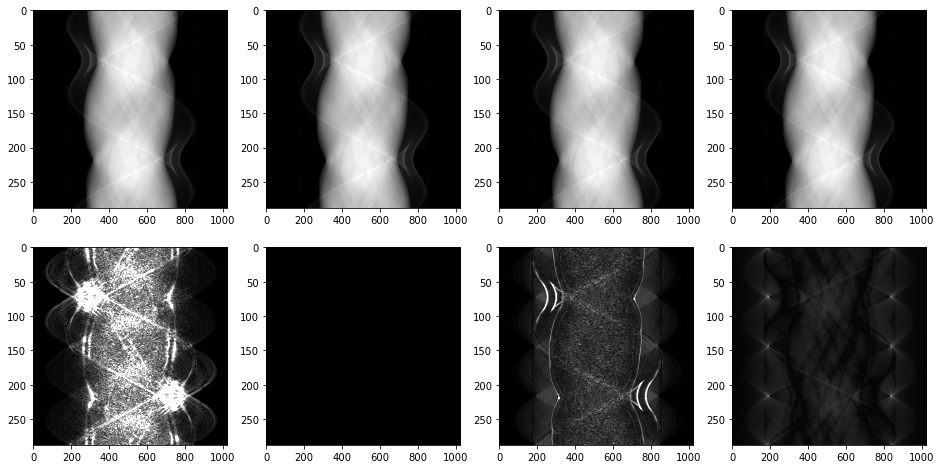

In [9]:
plt.figure(figsize=[16, 8])
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(prjs[show_name][show_tag[i]][0, :, show_slice, :], 'gray', vmin=0, vmax=400, aspect='auto')
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.abs(prjs[show_name][show_tag[i]] - prjs[show_name]['y'])[0, :, show_slice, :],
        'gray',
        vmin=0,
        vmax=1,
        aspect='auto'
    )

In [19]:
def calc_rmse(results, margin, norm, vmin=None, vmax=None, exclude=['ACR']):
    rmses = {}
    for name in results:
        rmses[name] = {}
        for tag in results[name]:
            diff = crop_window(results[name][tag], vmin, vmax) - crop_window(results[name]['y'], vmin, vmax)
            if margin > 0:
                diff = diff[..., margin:-margin, margin:-margin]
            rmses[name][tag] = np.mean(np.sqrt(np.mean(diff**2, (0, 2, 3)))) * norm
    mean_rmses = {}
    for tag in rmses[list(rmses.keys())[0]]:
        vals = np.array([rmses[name][tag] for name in rmses if name not in exclude])
        nslices = np.array([results[name][tag].shape[1] for name in results if name not in exclude])
        mean_rmses[tag] = np.sum(vals * nslices) / np.sum(nslices)
    rmses['mean'] = mean_rmses

    return rmses

In [20]:
def make_rmse_df(rmses_img, rmses_prj):
    # make dataframe
    cols = ['x', 'pred', 'postir']
    rows = []
    for name in rmses_img:
        row = {'Name': name}
        for col in cols:
            row[col] = rmses_img[name][col]
        rows.append(row)
    for name in rmses_prj:
        row = {'Name': name + ':prj'}
        for col in cols:
            row[col] = rmses_prj[name][col]
        rows.append(row)
    df_rmse = pd.DataFrame(rows)
    return df_rmse

In [21]:
# calc rmse
windows = {
    'Total': [None, None],
    'Liver': [0.84, 1.24],
    'Lung': [-0.35, 1.15],
    'Bone': [0.5, 2.3]
}

# no unit
rmses_prj = calc_rmse(prjs, 0, 0.019)

for name in windows:
    vmin = windows[name][0]
    vmax = windows[name][1]

    # HU
    rmses_img = calc_rmse(imgs, 96, 1000, vmin, vmax)
    df = make_rmse_df(rmses_img, rmses_prj)

    print(name)
    display.display(df)

Total


,Name,x,pred,postir
0,L291,24.485394,11.809153,12.395758
1,L143,24.719320,12.365313,12.586690
2,L067,26.169706,10.262980,11.115668
3,ACR,25.247917,4.291507,6.201562
4,mean,25.333910,11.390867,11.923372
5,L291:prj,0.013143,0.003687,0.001619
6,L143:prj,0.012964,0.003739,0.001546
7,L067:prj,0.014426,0.003603,0.001563
8,ACR:prj,0.016811,0.003966,0.001868
9,mean:prj,0.013511,0.003676,0.001576


Liver


,Name,x,pred,postir
0,L291,18.540557,9.680619,10.251280
1,L143,19.455936,10.069959,10.266913
2,L067,14.786628,7.615098,8.255971
3,ACR,6.659232,1.956269,3.181039
4,mean,17.321549,8.956401,9.383045
5,L291:prj,0.013143,0.003687,0.001619
6,L143:prj,0.012964,0.003739,0.001546
7,L067:prj,0.014426,0.003603,0.001563
8,ACR:prj,0.016811,0.003966,0.001868
9,mean:prj,0.013511,0.003676,0.001576


Lung


,Name,x,pred,postir
0,L291,23.573734,11.262943,11.822813
1,L143,24.134040,11.895817,12.097280
2,L067,25.365675,9.462563,10.291947
3,ACR,25.200995,4.066796,5.650019
4,mean,24.622163,10.768998,11.279464
5,L291:prj,0.013143,0.003687,0.001619
6,L143:prj,0.012964,0.003739,0.001546
7,L067:prj,0.014426,0.003603,0.001563
8,ACR:prj,0.016811,0.003966,0.001868
9,mean:prj,0.013511,0.003676,0.001576


Bone


,Name,x,pred,postir
0,L291,19.285537,10.129645,10.740472
1,L143,20.657415,10.861549,11.108156
2,L067,16.218793,8.357836,9.138489
3,ACR,7.444080,2.544651,3.768889
4,mean,18.581625,9.694565,10.209525
5,L291:prj,0.013143,0.003687,0.001619
6,L143:prj,0.012964,0.003739,0.001546
7,L067:prj,0.014426,0.003603,0.001563
8,ACR:prj,0.016811,0.003966,0.001868
9,mean:prj,0.013511,0.003676,0.001576


In [42]:
def save_snapshot(img, filename, vmin, vmax):
    img = (img - vmin) / (vmax - vmin) * 255
    img[img < 0] = 0
    img[img > 255] = 255
    img = img.astype(np.uint8)
    imageio.imwrite(filename, img)


def save_all_snapshot(imgs, output_dir, output_name, islice, vmin, vmax, margin, postfix='', mode='origin', is_prj=False):
    for tag in imgs:
        if is_prj:
            img_slice = imgs[tag][0, :, islice]
            y = imgs['y'][0, :, islice]
        else:
            img_slice = imgs[tag][0, islice]
            y = imgs['y'][0, islice]

        if mode == 'diff':
            img_slice = img_slice - y
        elif mode == 'abs_diff':
            img_slice = np.abs(img_slice - y)

        if margin > 0:
            img_slice = img_slice[margin:-margin, margin:-margin]
        save_snapshot(
            img_slice,
            os.path.join(output_dir, output_name + '.' + tag + postfix + '.' + str(islice) + '.png'),
            vmin,
            vmax
        )



In [43]:
# save_all_snapshot(imgs['L291'], output_dir, 'L291', 78, 0.84, 1.24, 96)
# save_all_snapshot(prjs['L291'], output_dir, 'L291', 78, 0, 400, 0, 'prj', is_prj=True)
# save_all_snapshot(prjs['L291'], output_dir, 'L291', 78, 0, 1, 0, 'prj_diff', 'abs_diff', is_prj=True)

In [44]:
save_all_snapshot(imgs['L143'], output_dir, 'L143', 322, 0.84, 1.24, 96)

In [14]:
# save_all_snapshot(imgs['ACR'], output_dir, 'ACR', 95, 0.84, 1.24, 160)